# **Ściąga**

Należy zaimplementować omawiane na wykładzie algorytmy wyznaczania otoczki wypukłej
dla zbioru punktów w przestrzeni dwuwymiarowej: przyrostowy, górna i dolna otoczka,
Quickhull, dziel i rządź oraz Chan’a. Porównać je między sobą oraz z algorytmami
zaimplementowanymi na ćwiczeniach (Grahama i Jarvisa). Dobrać odpowiednio zbiory
testowe. Porównać efektywność algorytmów.
Program powinien w sposób graficzny prezentować etapy konstrukcji otoczki ( w celu
objaśnienia działania algorytmu) dla każdego z algorytmów. Program ma służyć jako
narzędzie dydaktyczne do objaśnienia działania algorytmów.

Algorytmy:
- **algorytm przyrostowy** (slajd 12) 
- **górna i dolna otoczka** (slajd 17)
- algorytm Grahama
- algorytm Jarvisa
- **algorytm Quickhull** (slajd 31)
- **algorytm dziel i rządż** (dziwna ta nazwa...) (slajd 35)
- **algorytm Chan'a** (slajd 39)


# **Importy**

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import random

# **Aplikacja graficzna**

In [46]:
# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


figure_size = [8, 8]

# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure(figsize = figure_size)
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# **Struktury danych**

In [47]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.cw_next = None
        self.ccw_next = None
    
    def to_drawable(self):
        return (self.x, self.y)
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))

    def distance_to(self, other):
        return math.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    def subtract(self, p):
        return Point(self.x - p.x, self.y - p.y)


class Line:
    def __init__(self, p1 :Point, p2 :Point):
        if p1.x < p2.x:
            self.begin = p1
            self.end = p2
        else:
            self.begin = p2
            self.end = p1
    
    def is_crossing_with(self, other):
        A = self.begin
        B = self.end
        C = other.begin
        D = other.end
        
        d1 = det(A, B, C)
        d2 = det(A, B, D)
        d3 = det(C, D, A)
        d4 = det(C, D, B)
        
        if d1*d2 < 0 and d3*d4 < 0:
            return True
        
        if d1*d2 > 0 or d3*d4 > 0: 
            return False
        
        return True
    
    def get_crossing_point_with(self, other):
        if not self.is_crossing_with(other):
            return None
        
        X = lambda K, L: L.x - K.x
        Y = lambda K, L: L.y - K.y
        
        A = self.begin
        B = self.end
        C = other.begin
        D = other.end
        
        t1 = ( X(A,C)*Y(C,D) - Y(A,C)*X(C,D) )/( X(A,B)*Y(C,D) - Y(A,B)*X(C,D))
        t2 = ( X(A,C)*Y(A,B) - Y(A,C)*X(A,B) )/( X(A,B)*Y(C,D) - Y(A,B)*X(C,D))
        
        P = Point(0,0)
        P.x = A.x + t1 * X(A,B)
        P.y = A.y + t1 * Y(A,B)
        return P
    
    def to_drawable(self):
        return [self.begin.to_drawable(), self.end.to_drawable()]
    
class ConvexHull:
    
    def __init__(self):
        self.points = []
    
    def to_drawable(self):
        lines = []
        for i in range(len(self.points)-1):
            lines.append([self.points[i].to_drawable(), self.points[i+1].to_drawable()])
        lines.append([self.points[-1].to_drawable(), self.points[0].to_drawable()]) 
        return lines

    
def det(A: Point, B: Point, C:Point):
    v = Point(B.x-A.x, B.y-A.y)
    u = Point(C.x-A.x, C.y-A.y)
    v_len = math.sqrt(v.x*v.x + v.y*v.y)
    u_len = math.sqrt(u.x*u.x + u.y*u.y)
    vx = v.x / v_len
    vy = v.y / v_len
    ux = u.x / u_len
    uy = u.y / u_len
    d = v.x*u.y-u.x*v.y
    return d


In [48]:
import random
import math

def prepare_A(N: int, interval: [int]):
    return [Point(random.uniform(interval[0], interval[1]), random.uniform(interval[0], interval[1])) for i in range (N)]
    
def prepare_B(N: int, center: Point, radius: int):
    rands = [random.uniform(0,2*math.pi) for i in range(N)]
    return list(map(lambda t: Point(radius * math.cos(t) + center.x, radius * math.sin(t) + center.y), rands))

def prepare_C(N, vertices: [Point]):
    # assume that points are given counterclockwise from center rectangle
    len1 = vertices[0].distance_to(vertices[1])
    len2 = vertices[1].distance_to(vertices[2])
    n1 = int( N * len1 / (len1 + len2) )
    n2 = N - n1
    c1 = [(random.uniform(vertices[1].x, vertices[0].x),random.uniform(0,1)) for i in range(n1)]
    c1 = list(map(lambda p: Point(p[0], vertices[1].y if  p[1]>0.5 else vertices[2].y) ,c1))
    c2 = [(random.uniform(0,1), random.uniform(vertices[2].y, vertices[1].y)) for i in range(n2)]
    c2 = list(map(lambda p: Point(vertices[1].x if  p[0]>0.5 else vertices[0].x, p[1]), c2))
    
    return c1 + c2

def prepare_E(N, sec:[Point]):
    a = [sec[0].x, sec[0].y]
    b = [sec[1].x, sec[1].y]
    y = lambda x: ((a[1]-b[1])/(a[0]-b[0]))*x + (a[1] - ((a[1]-b[1])/(a[0]-b[0]))*a[0]) 
    rands = [random.uniform(a[0], b[0]) for i in range(N)]
    return list(map(lambda t: Point(t, y(t)), rands))
    

def prepare_D(N_on_axes, N_on_diagonals, vertices: [Point]):
    # assume that points given clokwise starting with (0,0)
    diag1 = prepare_E(N_on_diagonals, [vertices[0], vertices[2]])
    diag2 = prepare_E(N_on_diagonals, [vertices[1], vertices[3]])
    ax1 = [Point(vertices[0].x, random.uniform(vertices[0].y, vertices[1].y)) for i in range(N_on_axes)]
    ax2 = [Point(random.uniform(vertices[0].x, vertices[3].x), vertices[0].y) for i in range(N_on_axes)]
    p0 = [Point(vertices[0].x, vertices[0].y)]
    p1 = [Point(vertices[1].x, vertices[1].y)]
    p2 = [Point(vertices[2].x, vertices[2].y)]
    p3 = [Point(vertices[3].x, vertices[3].y)]
    return diag1 + diag2 + ax1 + ax2 + p0 + p1 + p2 + p3
    
points_set_dict = {    
    "A" : prepare_A(100, [-100, 100]),
    "B" : prepare_B(100, Point(0,0), 10),
    "C" : prepare_C(100, [Point(10,10), Point(-10,10), Point(-10,-10), Point(10, -10)]),
    "D" : prepare_D(25, 20, [Point(0,0), Point(0,10), Point(10,10), Point(10, 0)])
    }

points_set_name = input("Wprowadź rodzaj generowanego zbioru (A | B | C | D):\n")
points = points_set_dict[points_set_name]

Wprowadź rodzaj generowanego zbioru (A | B | C | D):
B


# **Manualne wczytanie zbioru punktów**

<IPython.core.display.Javascript object>


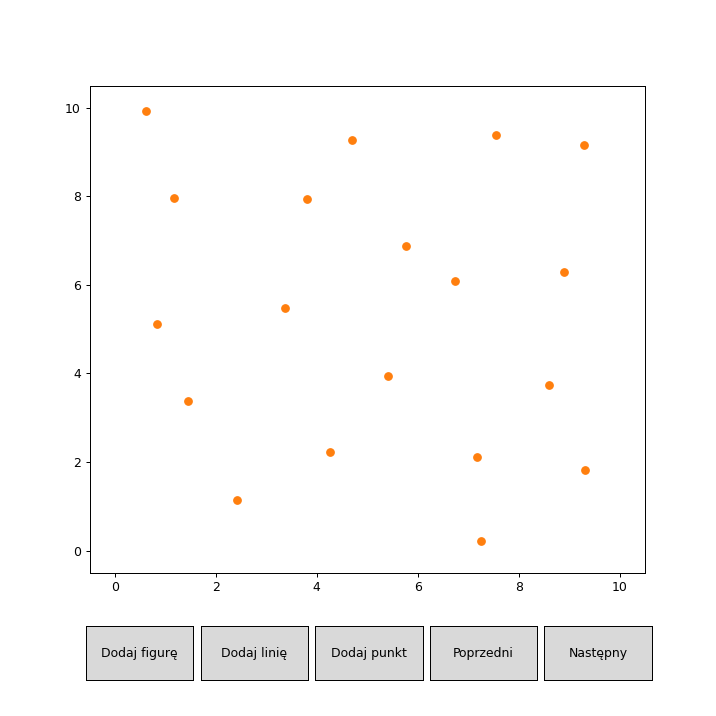

In [49]:
%matplotlib notebook
plot1 = Plot([Scene([PointsCollection([(0,0), (10,10)], s=0)])])
plot1.draw()

In [50]:
points = list(map(lambda p: Point(p[0], p[1]), plot1.get_added_points()[0].points))
points

# **Algorytm przyrostowy**

In [7]:
def algorithm1(points : [Point]):
    points_cp = list(map(lambda p: p.to_drawable(), points[:]))
    convexHull = ConvexHull()
    
    initial_indices = (random.randint(0,len(points)-1),random.randint(0,len(points)-1), random.randint(0,len(points)-1))
    while initial_indices[0] == initial_indices[1] or initial_indices[0] == initial_indices[2] or initial_indices[1] == initial_indices[2]:
        initial_indices = (random.randint(0,len(points)-1), random.randint(0,len(points)-1), random.randint(0,len(points)-1))
    A = points[initial_indices[0]]
    B = points[initial_indices[1]]
    C = points[initial_indices[2]]
    
    points.remove(A)
    points.remove(B)
    points.remove(C)
    
    if det(A,B,C) < 0:
        convexHull.points = [A, B, C]
    else:
        convexHull.points = [A, C, B]
        
    scenes = []
    scenes += [Scene(points=[PointsCollection(points_cp)], lines=[LinesCollection(convexHull.to_drawable())])]
    
    while points:
        p = points[0]
        points.remove(p)
        
        start_index = None
        end_index = None
        prev_orient = det(convexHull.points[-1], convexHull.points[0], p)
        for i in range(len(convexHull.points)):
            orient = det(convexHull.points[i], convexHull.points[(i+1)%len(convexHull.points)], p)
            if prev_orient * orient <= 0:
                if prev_orient <= 0:
                    start_index = i
                else:
                    end_index = i
            prev_orient = orient
            
        scenes += [Scene(points = [PointsCollection(points_cp), PointsCollection([p.to_drawable()], color="black")], 
                 lines = [LinesCollection(convexHull.to_drawable())])]
        
        if start_index is not None and end_index is not None:
            if start_index < end_index:
                convexHull.points = convexHull.points[:start_index+1] + [p] + convexHull.points[end_index:]
            else:
                convexHull.points = convexHull.points[end_index:start_index+1] + [p]
                
        scenes += [Scene(points = [PointsCollection(points_cp), PointsCollection([p.to_drawable()], color="black")], 
                         lines = [LinesCollection(convexHull.to_drawable())])]
    
    scenes += [Scene(points = [PointsCollection(points_cp)], 
                         lines = [LinesCollection(convexHull.to_drawable(), color="red")])]
    
    return convexHull, scenes
    

<IPython.core.display.Javascript object>


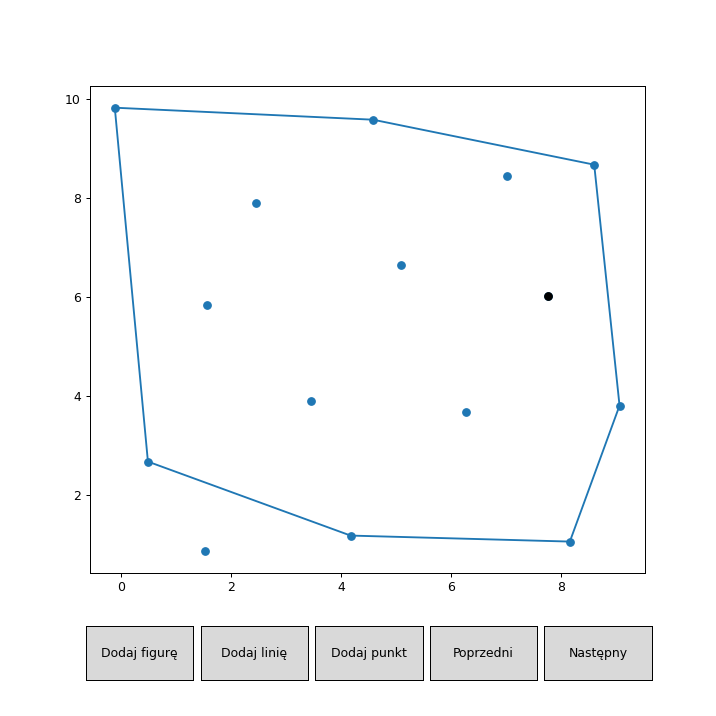

In [8]:
%matplotlib notebook
convexHull1, scenes1 = algorithm1(points[:])
visualisation1 = Plot(scenes1)
visualisation1.draw()

# **Górna i dolna otoczka**

In [9]:
def algorithm2(points: [Point]):
    points_cp = list(map(lambda p: p.to_drawable(), points[:]))
    points.sort(key=lambda p: [p.x, p.y])
    
    upConvexHull = ConvexHull()
    downConvexHull = ConvexHull()
    
    scenes = []
    scenes += [Scene(points=[PointsCollection(points_cp)])]
    
    upConvexHull.points = [points[0], points[1]]
    for i in range(2, len(points)):
        upConvexHull.points += [points[i]]
        
        scenes += [Scene(points = [PointsCollection(points_cp), PointsCollection([points[i].to_drawable()], color="black")], 
                         lines = [LinesCollection(upConvexHull.to_drawable()[:-1])])]
        
        while len(upConvexHull.points) > 2 and det(upConvexHull.points[-3], upConvexHull.points[-2], upConvexHull.points[-1]) > 0:
            upConvexHull.points = upConvexHull.points[:-2] + [upConvexHull.points[-1]]
            scenes += [Scene(points = [PointsCollection(points_cp), PointsCollection([points[i].to_drawable()], color="black")], 
                 lines = [LinesCollection(upConvexHull.to_drawable()[:-1])])]
    
    downConvexHull.points = [points[0], points[1]]
    for i in range(2, len(points)):
        downConvexHull.points += [points[i]]
        
        scenes += [Scene(points = [PointsCollection(points_cp), PointsCollection([points[i].to_drawable()], color="black")], 
                         lines = [LinesCollection(downConvexHull.to_drawable()[:-1]), LinesCollection(upConvexHull.to_drawable()[:-1])])]
        
        while len(downConvexHull.points) > 2 and det(downConvexHull.points[-3], downConvexHull.points[-2], downConvexHull.points[-1]) < 0:
            downConvexHull.points = downConvexHull.points[:-2] + [downConvexHull.points[-1]]
            scenes += [Scene(points = [PointsCollection(points_cp), PointsCollection([points[i].to_drawable()], color="black")], 
                 lines = [LinesCollection(downConvexHull.to_drawable()[:-1]), LinesCollection(upConvexHull.to_drawable()[:-1])])]
    
    downConvexHull.points.reverse()
    convexHull = ConvexHull()
    convexHull.points = upConvexHull.points + downConvexHull.points[1:-1]
    scenes += [Scene(points = [PointsCollection(points_cp)], 
         lines = [LinesCollection(convexHull.to_drawable(), color='red')])]
    
    return convexHull, scenes

<IPython.core.display.Javascript object>


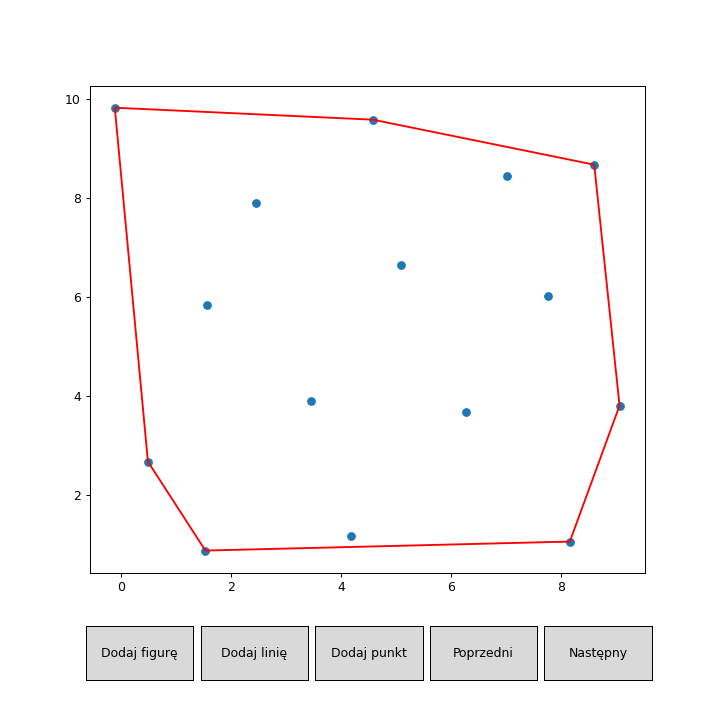

In [10]:
%matplotlib notebook
convexHull2, scenes = algorithm2(points[:])
visualisation2 = Plot(scenes)
visualisation2.draw()

# **Algorytm Grahama**

In [11]:
def retreive_p0(points:[]):
    min_y = min(list(map(lambda x: x[1], points)))
    all_mins = list(filter(lambda x: x[1]==min_y, points))
    min_x = min(list(map(lambda x: x[0], all_mins)))
    p0 = (list(filter(lambda x: x[0] == min_x and x[1] == min_y, points)))[0]
    points.remove(p0)
    return (min_x, min_y)

def distance_between(v,u):
    return np.linalg.norm([v[0] - u[0], v[1] - u[1]])

def angle_with_OX(point, p0):
    v = Point(point[0] - p0[0], point[1] - p0[1])
    v_len = math.sqrt(v.x*v.x + v.y*v.y)
    Px = v.x/v_len
    Py = v.y/v_len
    return math.atan2(Py, Px)

def orient_on_left(A, B, C):
    return det(Point(A[0],A[1]),Point(B[0],B[1]),Point(C[0],C[1])) > 0
    
def algorithm3(points :[Point]):
    points = [p.to_drawable() for p in points]
    scenes = []
    p0 = retreive_p0(points)
    scenes += [Scene([PointsCollection(points[:]), 
               PointsCollection([p0], color='red')])] 
    angle_point = {}
    for point in points:
        key = angle_with_OX(point, p0)
        if key not in angle_point.keys():
            angle_point[key] = (point[0], point[1], key)
        else:
            if distance_between(point, p0) > angle_point[key][0]:
                angle_point[key] = (point[0], point[1], key)
    candidates = list(angle_point.values())
    candidates.sort(key=lambda x: x[2])
    candidates = list(map(lambda x: (x[0], x[1]), candidates))
    
    background_points = [PointsCollection(points[:]), 
                      PointsCollection(candidates[:], color="green"),
                      PointsCollection([p0], color='red')]
    background_lines = [LinesCollection([[p0,p] for p in candidates], color="black")]
    scenes += [Scene(background_points, background_lines)]
    
    i=2
    stack = [p0, candidates[0], candidates[1]]
    while(i < len(candidates)):
        current = candidates[i]
        if orient_on_left(stack[-2], stack[-1], current):
            stack += [current]
            i += 1
            scenes += [Scene(background_points + [PointsCollection([current], color="black")], [LinesCollection([[stack[k-1], stack[k]] for k in range(1, len(stack))],color="green")])]
        else:
            scenes += [Scene(background_points + [PointsCollection([current], color="black")], [LinesCollection([[stack[-1], current]], color="red"),LinesCollection([[stack[k-1], stack[k]] for k in range(1, len(stack))],color="green")])]
            stack = stack[:-1]

    scenes += [Scene(background_points, [LinesCollection([[stack[k-1], stack[k]] for k in range(len(stack))],color="green")])]
    convexHull = ConvexHull()
    convexHull.points = [Point(p[0],p[1]) for p in stack]
    return convexHull, scenes


<IPython.core.display.Javascript object>


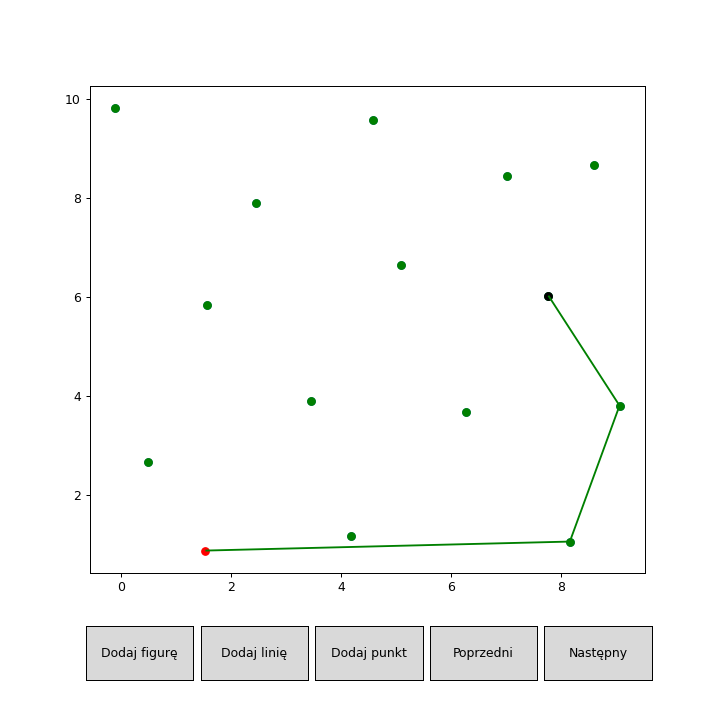

In [17]:
%matplotlib notebook
convexHull3, scenes = algorithm3(points[:])
visualisation3 = Plot(scenes)
visualisation3.draw()

In [81]:
# **Algorytm Divide and conquer**

In [51]:
def cross_product(p1, p2):
    return p1.x * p2.y - p2.x * p1.y

def direction(p1, p2, p3):
    return  cross_product(p3.subtract(p1), p2.subtract(p1))

def merge(all_p, chull1, chull2, scene):
    for i in range(len(chull1)):
        if i != len(chull1) - 1:
            chull1[i].ccw_next = chull1[i+1]
        else:
            chull1[i].ccw_next = chull1[0]
        if i != 0:
            chull1[i].cw_next = chull1[i-1]
        else:
            chull1[i].cw_next = chull1[len(chull1) - 1]
            
    for i in range(len(chull2)):
        if i != len(chull2) - 1:
            chull2[i].ccw_next = chull2[i+1]
        else:
            chull2[i].ccw_next = chull2[0]
        if i != 0:
            chull2[i].cw_next = chull2[i-1]
        else:
            chull2[i].cw_next = chull2[len(chull2) - 1]
            
    p = max(chull1, key = lambda point: point.x)

    q = min(chull2, key = lambda point: point.x)

    cp_p = p
    cp_q = q

    prev_p = None
    prev_q = None
    while (True):
        prev_p = p
        prev_q = q
        if q.cw_next:
            while direction(p, q, q.cw_next) < 0:
                q = q.cw_next
        if p.ccw_next:
            while direction(q, p, p.ccw_next) > 0:
                p = p.ccw_next

        if p == prev_p and q == prev_q:
            break
    
    prev_p = None
    prev_q = None
    while (True):
        prev_p = cp_p
        prev_q = cp_q
        if cp_q.ccw_next:
            while direction(cp_p, cp_q, cp_q.ccw_next) > 0:
                cp_q = cp_q.ccw_next
        if cp_p.cw_next:
            while direction(cp_q, cp_p, cp_p.cw_next) < 0:
                cp_p = cp_p.cw_next
        if cp_p == prev_p and cp_q == prev_q:
            break

    p.cw_next = q
    q.ccw_next = p

    cp_p.ccw_next = cp_q
    cp_q.cw_next = cp_p

    result = []
    start = p 
    while (True):
        result.append(p)
        p = p.ccw_next

        if p == start:
            break
            
    convexHull = ConvexHull()
    convexHull.points = result
    
    scene += [Scene([PointsCollection([p.to_drawable() for p in all_p])],[LinesCollection(convexHull.to_drawable(), color='red')])]
    return result

def algorithm6(all_p, points :[Point], scene):
    if len(points) <= 2:
        if len(points) == 2:
            scene += [Scene([PointsCollection([p.to_drawable() for p in all_p])],
                            [LinesCollection([[points[0].to_drawable(), points[1].to_drawable()]])])] 
        return points, scene
    
    points.sort(key=lambda p: [p.x, p.y])
    half = 0
    if len(points)%2 == 1:
        half = (len(points) - 1)//2
    else:
        half = len(points)//2
    
    left_half, scene1 = algorithm6(all_p, points[0: half], scene)
    right_half, scene2 = algorithm6(all_p, points[half:], scene)
    return merge(all_p, left_half, right_half, scene), scene
  

<IPython.core.display.Javascript object>


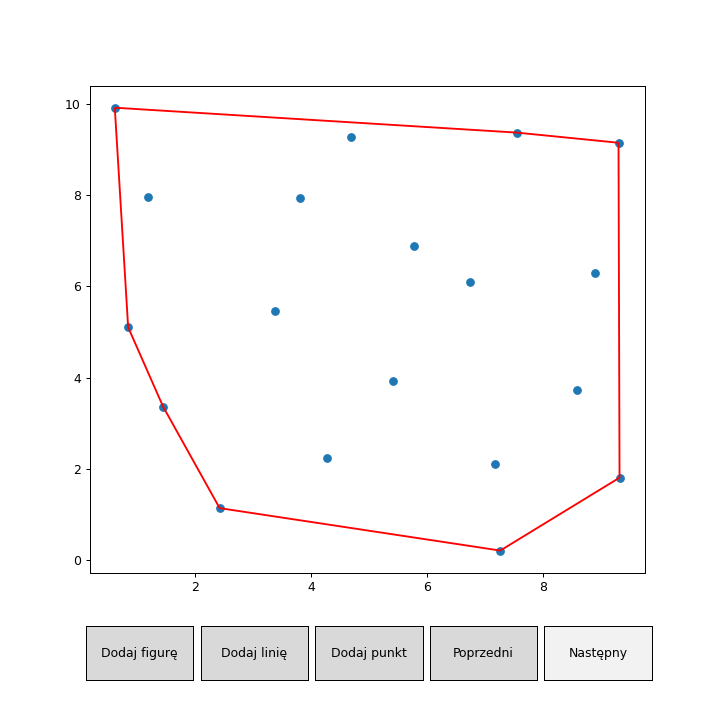

18


In [52]:
%matplotlib notebook
scenes = []
all_points = points
convexHull6, scenes1 = algorithm6(all_points[:], points[:], scenes)
convexHull6 = [p.to_drawable() for p in convexHull6]
visualisation6 = Plot([Scene([PointsCollection([p.to_drawable() for p in all_points])])])
visualisation6.add_scenes(scenes1)
visualisation6.draw()
print(len(scenes))

In [ ]:
# **Algorytm Chan'a**

In [112]:
from math import atan2, degrees
 
def getAngle(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + degrees(atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + degrees(atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def retreive_p0(points:[]):
    min_y = min(list(map(lambda x: x[1], points)))
    all_mins = list(filter(lambda x: x[1]==min_y, points))
    min_x = min(list(map(lambda x: x[0], all_mins)))
    p0 = (list(filter(lambda x: x[0] == min_x and x[1] == min_y, points)))[0]
    points.remove(p0)
    return (min_x, min_y)

def distance_between(v,u):
    return np.linalg.norm([v[0] - u[0], v[1] - u[1]])

def angle_with_OX(point, p0):
    v = Point(point[0] - p0[0], point[1] - p0[1])
    v_len = math.sqrt(v.x*v.x + v.y*v.y)
    Px = v.x/v_len
    Py = v.y/v_len
    return math.atan2(Py, Px)

def orient_on_left(A, B, C):
    return det(Point(A[0],A[1]),Point(B[0],B[1]),Point(C[0],C[1])) > 0
    
def Graham_for_part(points :[Point], all_p):
    points = [p.to_drawable() for p in points]
    all_p = [p.to_drawable() for p in all_p]
    scenes = []
    p0 = retreive_p0(points)
    scenes += [Scene([PointsCollection(all_p[:]), 
               PointsCollection([p0], color='red')])] 
    angle_point = {}
    for point in points:
        key = angle_with_OX(point, p0)
        if key not in angle_point.keys():
            angle_point[key] = (point[0], point[1], key)
        else:
            if distance_between(point, p0) > angle_point[key][0]:
                angle_point[key] = (point[0], point[1], key)
    candidates = list(angle_point.values())
    candidates.sort(key=lambda x: x[2])
    candidates = list(map(lambda x: (x[0], x[1]), candidates))
    
    background_points = [PointsCollection(all_p[:]), 
                      PointsCollection(candidates[:], color="green"),
                      PointsCollection([p0], color='red')]
    background_lines = [LinesCollection([[p0,p] for p in candidates], color="black")]
    scenes += [Scene(background_points, background_lines)]
    
    i=2
    stack = [p0, candidates[0], candidates[1]]
    while(i < len(candidates)):
        current = candidates[i]
        if orient_on_left(stack[-2], stack[-1], current):
            stack += [current]
            i += 1
            scenes += [Scene(background_points + [PointsCollection([current], color="black")], [LinesCollection([[stack[k-1], stack[k]] for k in range(1, len(stack))],color="green")])]
        else:
            scenes += [Scene(background_points + [PointsCollection([current], color="black")], [LinesCollection([[stack[-1], current]], color="red"),LinesCollection([[stack[k-1], stack[k]] for k in range(1, len(stack))],color="green")])]
            stack = stack[:-1]

    scenes += [Scene(background_points, [LinesCollection([[stack[k-1], stack[k]] for k in range(len(stack))],color="green")])]
    linesFinal = LinesCollection([[stack[k-1], stack[k]] for k in range(len(stack))],color="green")
    convexHull = ConvexHull()
    convexHull.points = [Point(p[0],p[1]) for p in stack]
    points = [Point(p[0],p[1]) for p in stack]
    return convexHull, scenes, linesFinal, points

def split_list(the_list, chunk_size):
    result_list = []
    while the_list:
        result_list.append(the_list[:chunk_size])
        the_list = the_list[chunk_size:]
    return result_list


def algorithm7(n, points :[Point], scene):
    lines = LinesCollection([])
    all_lines = []
    hulls = []
    counter = 0
    points.sort(key=lambda p: [p.x, p.y])
    all_p = points
    parts = split_list(points, n)
    for i in parts:
        convexHull, scenes, lines, points = Graham_for_part(i ,all_p)
        all_lines.append(lines)
        hulls.append(points)
        scene += scenes
        scene += [Scene([PointsCollection([p.to_drawable() for p in all_p])], all_lines)]
        all_lines = all_lines.copy()
    bg_points = [PointsCollection([p.to_drawable() for p in all_p])]
    scene += [Scene(bg_points, all_lines)]
    
    result = hulls[0]
    for i in range(1, len(hulls)):
        result = merge(all_p, result, hulls[i], scene)
    
    return scene, lines
    
    

<IPython.core.display.Javascript object>


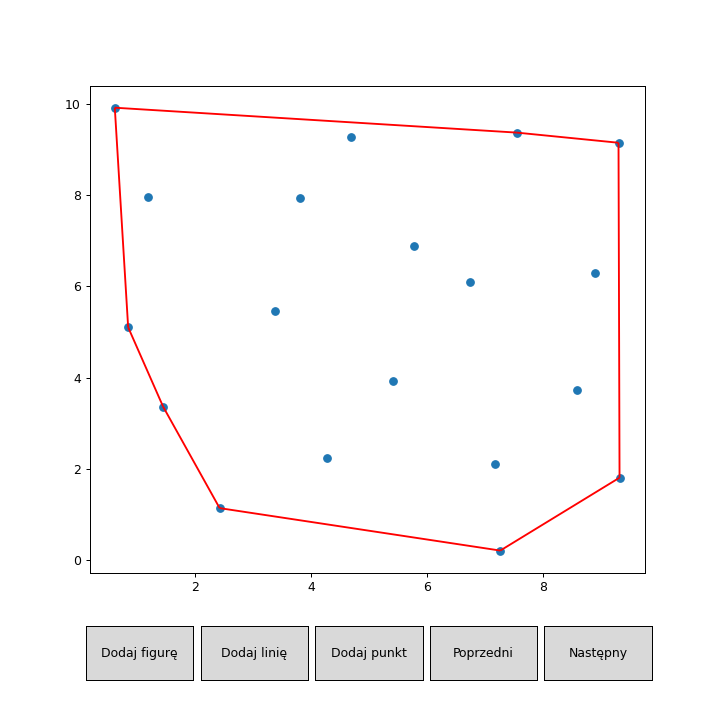

In [113]:
%matplotlib notebook
scene = []
scenes, lines = algorithm7(5, points[:], scene)
visualisation3 = Plot(scenes)
visualisation3.draw()